In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sklearn
from sklearn import model_selection
import prepare

In [11]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)

In [12]:
dataset = pd.read_csv("virus_data.csv")
training_set, test_set = sklearn.model_selection.train_test_split(dataset,test_size = 0.2, random_state = 53)

train_df_prepared = prepare.prepare_data(training_set, training_set)
test_df_prepared = prepare.prepare_data(training_set, test_set)

C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('blood_type', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('pcr_date', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('symptoms', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df = self.df.drop('current_location', 1)
C:\Users\97254\OneDrive\Desktop\Major2_ML\prepare.py:41: FutureWarning: In a f

Text(0.5, 0.98, 'jointplot PCR_01 PCR_02')

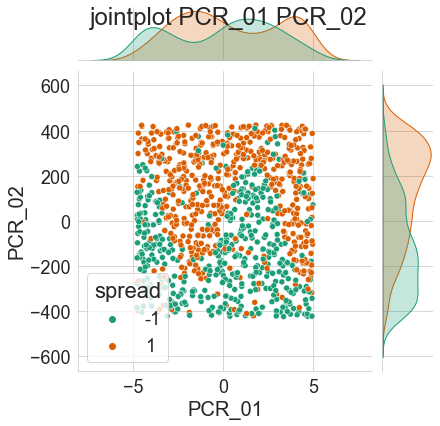

In [14]:
tmp_df = training_set[["spread", "PCR_01", "PCR_02"]]
p_PCR01_PCR02 = sns.jointplot(data=tmp_df, x='PCR_01', y='PCR_02', hue='spread', palette = "Dark2")
p_PCR01_PCR02.fig.suptitle("jointplot PCR_01 PCR_02")